<a href="https://colab.research.google.com/github/vieduy/CS114.K21/blob/master/CaseStudy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mô tả bài toán
- Trước đây chúng ta đã từng gặp bài toán phân tích một câu tweet của một user là châm biếm hay không. Nhưng dataset chứa những câu tweet gặp rất nhiều noise.
- Để vượt qua nhiễu trong dataset trên thì bài toán phân tích headline từ hai trang web là HuffPost và TheOnion đã ra đời
- Dataset được tạo bằng cách collect headlines từ một trang chuyên viết về tin châm biếm (TheOnion), và trang chỉ chuyên về tin chính thống (HuffPost) 
- Nhiệm vụ của chúng ta là phải phân biệt được headline nào là châm biếm(is_sarcastic = 1) và headline nào không phải châm biếm (is_sarcastic = 0)

# Dataset 2000 headlines tự thu thập như thế nào?
- 1000 headlines non-sarcasm được bạn Việt collect sử dụng extension Data-Miner
- 1000 headlines sarcasm còn lại được em thu thập bằng cách viết 1 module bằng python. Đầu tiên ta lấy tất cả content trong file HTML của trang báo. Sau đó lọc lại chỉ lấy mỗi headline cần thiết. Sau đó gán nhãn là 1 cho tất cả các headlines và lưu lại dưới dạng .csv

In [ ]:
!pip install pandas requests bs4

In [ ]:
import bs4
import pandas as pd
import requests

In [ ]:
headlines = []
url = 'https://www.theonion.com/latest?startTime=1582633800457' # các bạn thay link của trang mình cần lấy dữ liệu tại đây
def get_page_content(url):
   page = requests.get(url,headers={"Accept-Language":"en-US"})
   return bs4.BeautifulSoup(page.text,"html.parser")
soup = get_page_content(url)

In [ ]:
headlines = soup.findAll('h2', class_='sc-759qgu-0 cYlVdn cw4lnv-6 eXwNRE')
titles = [headline.text for headline in headlines]
headlines.extend(titles)

In [ ]:
dict = {'is_sarcastic': np.ones((len(headlines),), dtype=int), 'headline': headlines} 
df = pd.DataFrame(dict) 

# saving the dataframe 
df.to_csv('data_1.csv') 

# Import các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
import tensorflow as tf

# Đọc file data chứa 1000 headlines của HuffPost và The Onion

In [ ]:
df = pd.read_csv("dataminer.csv", encoding="unicode_escape")
df['is_sarcastic'] = 0
df.columns = ['headline', 'is_sarcastic']
column_names = ['is_sarcastic', 'headline']
df = df.reindex(columns=column_names)
df.head(5)

is_sarcastic                                           headline
0             0  After Weeks Of Anticipation, Trump Rally Crowd...
1             0  Trump Camp Lashes Media, 'Radical Protesters' ...
2             0  Trump Fires U.S. Attorney Who Led Probes Of Th...
3             0  Public Enemy Tells 'Dictator' Trump To Shut T...
4             0  Who Owns A River? The Question Is Tearing This...

In [ ]:
df_union = pd.read_csv("theunion.csv")
df_union.drop(df_union.columns[df_union.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_union.columns = ['is_sarcastic', 'headline']
df_union.head(5)

is_sarcastic                                           headline
0             1  Mental Health Experts Advise On Best Ways To C...
1             1  The Onion’s Father’s Day Gift Guide For The Da...
2             1  Staples Center Employee Realizes He Left Shot ...
3             1  Father’s Day Gifts That Will Make Your Dad Fee...
4             1  Huh, Boyfriend’s Ex Just Made Interesting Hair...

# Merge 2 dataset lại với nhau

In [ ]:
df_merged = df.append(df_union)
print(df_merged)

      is_sarcastic                                           headline
0                0  After Weeks Of Anticipation, Trump Rally Crowd...
1                0  Trump Camp Lashes Media, 'Radical Protesters' ...
2                0  Trump Fires U.S. Attorney Who Led Probes Of Th...
3                0  Public Enemy Tells 'Dictator' Trump To Shut T...
4                0  Who Owns A River? The Question Is Tearing This...
...            ...                                                ...
1007             1             Forever 21 Bought Following Bankruptcy
1008             1  Trump Administration Rolls Back Hunting Regula...
1009             1  Pete Alonso Asks Teammates Whether They’d All ...
1010             1  Anti-Cyberbullying Campaign Encourages Kids To...
1011             1    Roger Stone Sentenced To Over 3 Years In Prison

[2017 rows x 2 columns]


# Lấy dataset trên kaggle

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"duyhoangvien","key":"0952d645a4b4335830e2e94ecdd947d0"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Jun 22 07:48 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection/kernels

news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
replace Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

is_sarcastic  ...                                       article_link
0             1  ...  https://www.theonion.com/thirtysomething-scien...
1             0  ...  https://www.huffingtonpost.com/entry/donna-edw...
2             0  ...  https://www.huffingtonpost.com/entry/eat-your-...
3             1  ...  https://local.theonion.com/inclement-weather-p...
4             1  ...  https://www.theonion.com/mother-comes-pretty-c...

[5 rows x 3 columns]

In [ ]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

# Xử lý dữ liệu
Mục tiêu là chúng ta sẽ loại bớt những char không cần thiết cho việc phân loại trong headline bao gồm:
- Bỏ cột article_link
- Dấu ngoặc (ex: { [ ( )
- Chấm câu (ex: . ; ' `.)
- Stop words(những từ không có nghĩa): a, the, an...

# Bỏ cột article_link

In [ ]:
del df['article_link'] # Deleting this column as it is of no use

In [ ]:
df.head()

is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails why congress is falling...
2             0  eat your veggies: 9 deliciously different recipes
3             1  inclement weather prevents liar from getting t...
4             1  mother comes pretty close to using word 'strea...

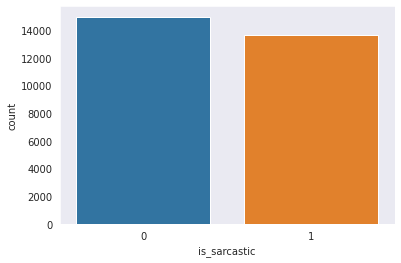

In [ ]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

# Lưu lại 1 list các stop words

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'ma', 'can', 'again', 'being', 'whom', 'o', 'only', 'as', 'under', 'did', 's', 'just', 'haven', 'between', "you've", 'all', 'each', 'mustn', 't', 'more', 're', 'an', 'these', 'aren', 'other', 'same', 'any', 'off', "aren't", 'weren', '\\', 'should', 'we', 'further', ';', "mustn't", 'for', "isn't", 've', 'herself', 'some', 'himself', 'hasn', "mightn't", 'are', "weren't", 'at', 'when', "wouldn't", 'so', 'but', '`', 'this', 'of', '!', 'be', 'until', 'didn', 'with', '|', 'after', 'her', 'shouldn', 'theirs', 'who', 'nor', 'most', '$', 'yours', 'into', 'it', 'not', "that'll", 'from', 'yourselves', 'now', 'been', 'was', 'and', "she's", 'having', 'those', "you'll", 'hers', 'then', 'against', "shouldn't", '<', '>', 'themselves', 'myself', 'wasn', 'i', "it's", '^', 'had', 'about', 'above', 'own', '~', 'up', "won't", 'here', '.', 'do', 'isn', 'such', 'or', 'during', 'ourselves', 

# Các hàm dùng để làm sạch data (Preprocesing dataset)
# - Hàm loại bỏ stop words và các dấu ngoặc...

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

# Riêng data tự thu thập thì cần thêm hàm lower_case để đưa headline về chữ thường 

In [ ]:
def lower_case(text):
      final_text = []
      for i in text.split():
          i.strip().lower()
          final_text.append(i.strip().lower())
      return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = lower_case(text)
    return text

In [ ]:
print(lower_case('Duyy the a;..'))

duyy the a;..


In [ ]:
df_merged['headline'] = df_merged['headline'].apply(denoise_text)
print(df_merged['headline'])

0       weeks anticipation, trump rally crowd underwhelms
1       trump camp lashes media, 'radical protesters' ...
2       trump fires u.s. attorney led probes president...
3       public enemy tells 'dictator' trump shut f**k...
4            owns river? question tearing community apart
                              ...                        
1007               forever 21 bought following bankruptcy
1008    trump administration rolls back hunting regula...
1009    pete alonso asks teammates whether they’d rath...
1010    anti-cyberbullying campaign encourages kids ge...
1011                 roger stone sentenced 3 years prison
Name: headline, Length: 2017, dtype: object


# Word Cloud của HuffPost trên Kaggle

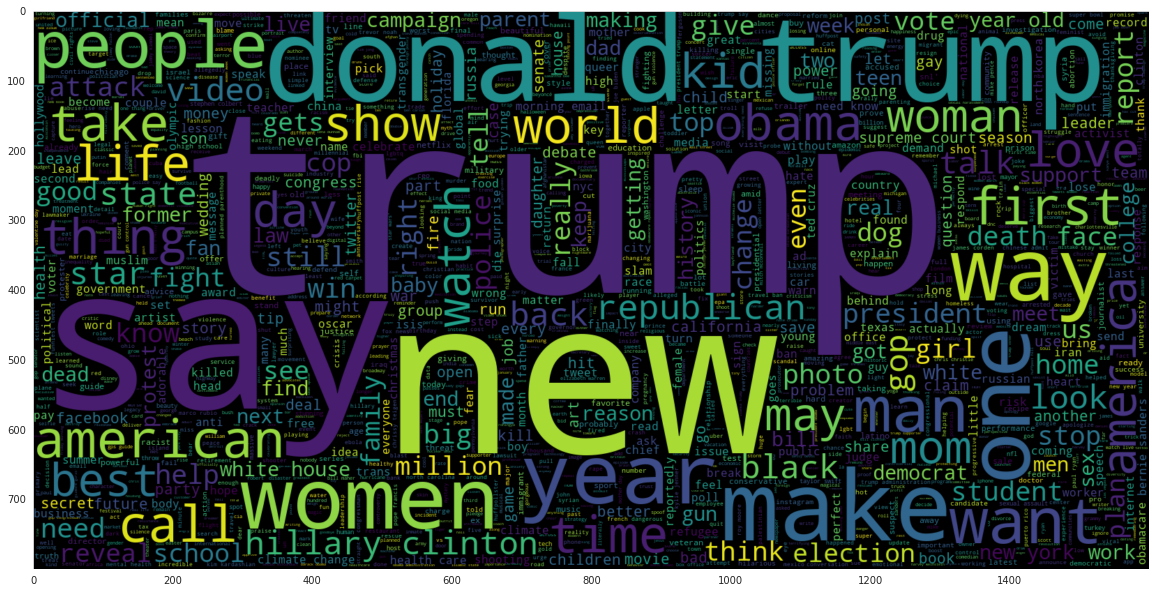

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

# Word Cloud của HuffPost trên 1000 headlines tự collect

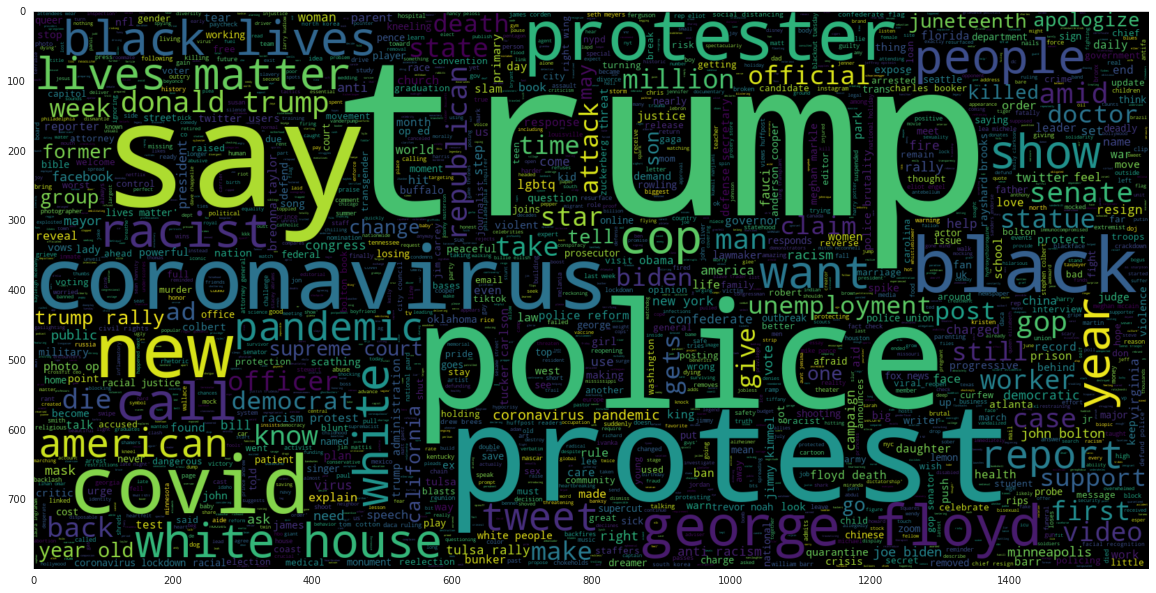

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_merged[df_merged.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

# Word Cloud của TheOnion trên Kaggle

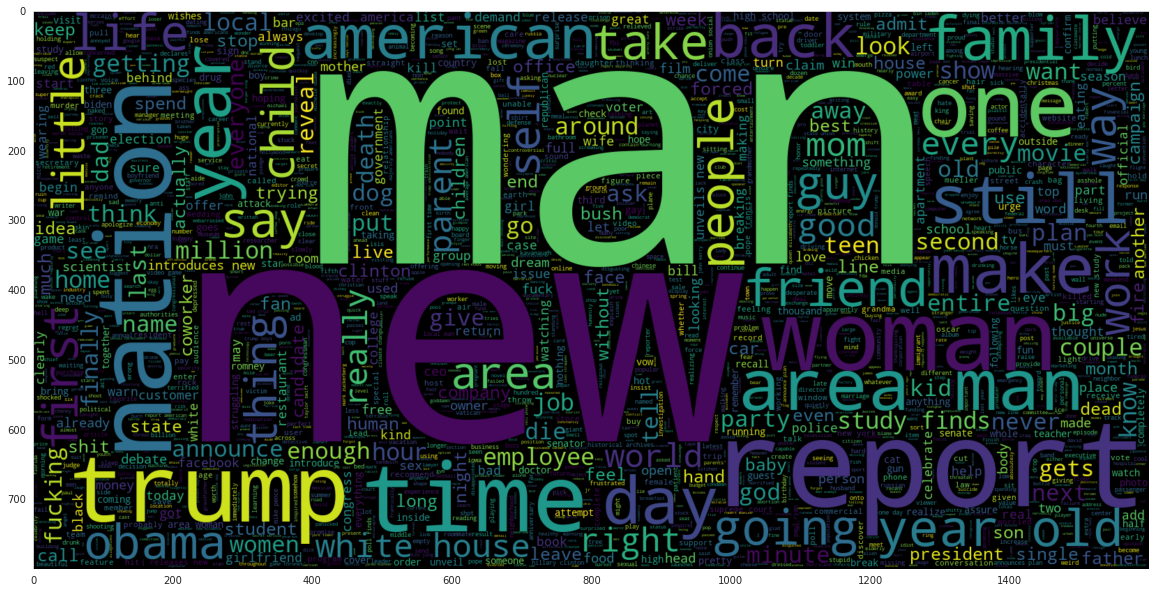

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

# Word Cloud của TheOnion trên 1000 headlines tự collect

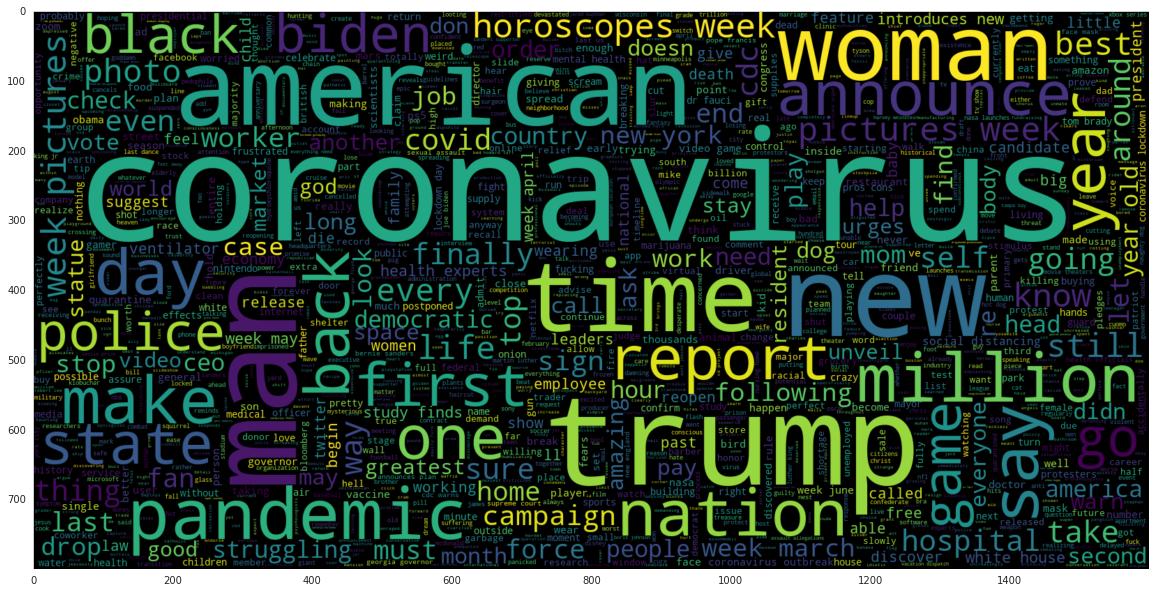

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_merged[df_merged.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

# Visualize số ký tự trong 1 headlines của dataset trên Kaggle và data tự collect

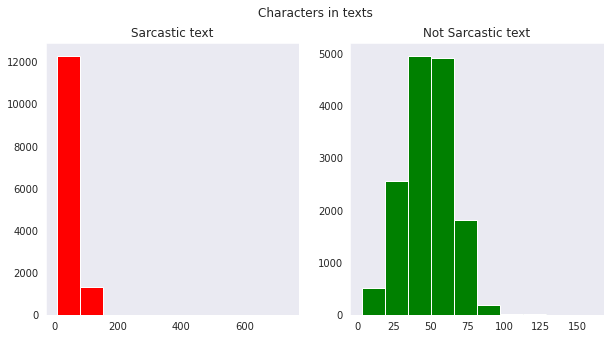

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

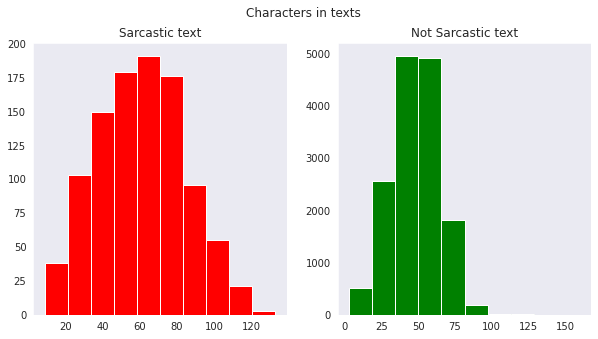

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df_merged[df_merged['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

# Số từ trung bình trong một headline

Text(0.5, 0.98, 'Average word length in each text')

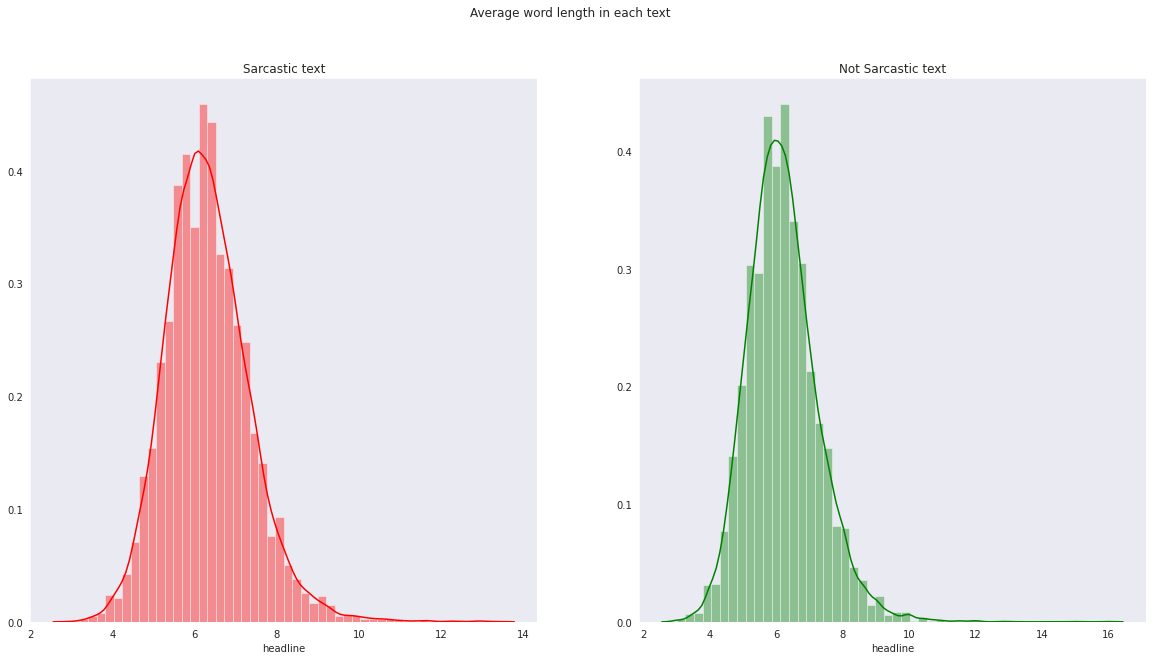

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

# Tách các từ riêng lẻ từ các headlines

In [ ]:
words = []
for i in df.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)

In [ ]:
words_new = []
for i in df_merged.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words_new.append(l)

In [ ]:
print(np.shape(words_new))

(2017,)


# Dùng word2vec để tính trọng số của các từ trong từ điển

In [ ]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 200dim vector
print(w2v_model.most_similar('women')[:5])
print(w2v_model['yellow'])

# Feature Engineering
Vectorize các headline theo cách đưa các từ trong array words vào từ điển
- Key là các word trong array words.
- Value tỉ lệ nghịch với freq của từ đó trong các headlines. Ví dụ từ trump xuất hiện nhiều nên values là 2.(ex: 'trump' : 2)
- Cuối cùng ta thay thế các từ trong mỗi headlines bằng các values trong từ điển.
- Sau khi vectorize các headline ta đưa chúng về cùng shape (20, 1) bằng cách chèn thêm các số 0 phía trước.

In [ ]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)
print(tokenized_train)

[[16792, 231, 2832, 7173, 2336, 558, 944], [7174, 2484, 588, 2833, 134, 1725, 1136, 11455, 1990, 1810], [782, 16793, 545, 16794, 480, 1357], [11456, 1520, 6093, 8795, 56, 72], [360, 345, 197, 913, 409, 510, 16795, 6094], [20, 11457], [39, 162, 3854, 2638, 450, 1450], [1582, 16796, 11458, 2834, 914, 131, 1398, 1245, 3044, 3855], [2639, 193, 56, 1726, 308, 16797, 1583, 246, 3856], [2640, 73, 45, 8796], [2337, 3045, 339, 3857, 1451, 882, 4, 16798], [7175, 11459, 481, 421, 147, 1137, 511, 16799], [45, 11460, 1452, 11461, 1014], [410, 1655, 758, 66, 27, 1584, 8797, 16800, 7176, 945, 11462], [1358, 3858, 1, 6095, 1302, 11463, 8798], [1209, 260, 7177, 8799, 4697, 3, 1453, 7178, 1991], [5, 346, 946, 16801, 3046], [5, 2, 2199, 11464], [422, 327, 3269, 220], [3533, 2641, 32, 12, 2200, 284, 411, 168], [1992, 1454, 272, 947, 3859, 1246, 648, 2835], [1455, 71, 190, 4698, 1015, 1811, 3047, 8800, 16802], [206, 16803], [423, 4699, 2338, 92, 101], [35, 27, 1893, 11465, 354, 3534, 16804, 376], [266, 361

In [ ]:
print(tokenizer.word_index)

{'new': 1, 'man': 2, 'trump': 3, 'one': 4, 'area': 5, 'woman': 6, 'says': 7, 'donald': 8, 'report:': 9, 'u.s.': 10, 'day': 11, 'like': 12, 'get': 13, 'first': 14, 'time': 15, "trump's": 16, 'people': 17, 'still': 18, 'house': 19, 'white': 20, 'make': 21, 'life': 22, 'obama': 23, 'back': 24, 'women': 25, 'could': 26, 'clinton': 27, 'americans': 28, 'way': 29, 'world': 30, 'family': 31, 'would': 32, 'gop': 33, 'finds': 34, 'bill': 35, 'really': 36, 'black': 37, 'years': 38, '5': 39, "can't": 40, 'school': 41, 'police': 42, 'best': 43, 'nation': 44, 'know': 45, 'going': 46, 'every': 47, 'american': 48, 'last': 49, 'death': 50, "'the": 51, 'say': 52, 'state': 53, 'campaign': 54, 'home': 55, 'getting': 56, 'health': 57, 'things': 58, 'president': 59, 'mom': 60, 'good': 61, 'may': 62, 'show': 63, 'big': 64, 'gets': 65, 'hillary': 66, 'year': 67, 'need': 68, 'little': 69, 'take': 70, 'video': 71, 'work': 72, 'parents': 73, 'study': 74, 'makes': 75, 'love': 76, 'john': 77, 'never': 78, 'watch'

In [ ]:
print(words)

[['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock', 'hair', 'loss'], ['dem', 'rep.', 'totally', 'nails', 'congress', 'falling', 'short', 'gender,', 'racial', 'equality'], ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'], ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'], ['mother', 'comes', 'pretty', 'close', 'using', 'word', "'streaming'", 'correctly'], ['white', 'inheritance'], ['5', 'ways', 'file', 'taxes', 'less', 'stress'], ['richard', "branson's", 'global-warming', 'donation', 'nearly', 'much', 'cost', 'failed', 'balloon', 'trips'], ['shadow', 'government', 'getting', 'large', 'meet', 'marriott', 'conference', 'room', 'b'], ['lots', 'parents', 'know', 'scenario'], ['lesbian', 'considered', 'father', 'indiana', '(and', 'amazing', 'one', 'that)'], ['amanda', 'peet', 'told', 'daughter', 'sex', "'a", 'special', "hug'"], ['know', 'regarding', 'current', 'treatments', 'ebola'], ['chris', 'christie', 'suggests', 'hillary', 'clinton', 'blame', '

# Chuyển headline tự collect thành vector bằng cách ignore những từ không có trong từ điển 

In [ ]:
test = []
for i in words_new:
  l = []
  for j in i:
    if j not in list(tokenizer.word_index):
      continue
    else:
      l.append(tokenizer.word_index[j])
  test.append(l)

In [ ]:
print(np.shape(test))
test_head = sequence.pad_sequences(test, maxlen = 20)

(2017,)


# Tăng độ dài từ điển lên 1 vì lúc khởi tạo lớp Embedding thì cần thêm 1 vector cho những từ unknows

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

# Hàm lấy weight từ model word2vec

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


38072


# Khởi tạo model RNN + LSTM và các layer cần sử dụng

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 7,951,553
Trainable params: 7,951,553
Non-trainable params: 0
_________________________________________________________________


# Phân chia tập dữ liệu cho train-test set

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

# Training model

In [ ]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/3
20033/20033 [==============================] - 16s 820us/step - loss: 0.5177 - acc: 0.7332 - val_loss: 0.4158 - val_acc: 0.8100
Epoch 2/3
20033/20033 [==============================] - 15s 771us/step - loss: 0.1516 - acc: 0.9437 - val_loss: 0.5241 - val_acc: 0.8006
Epoch 3/3
20033/20033 [==============================] - 15s 765us/step - loss: 0.0368 - acc: 0.9873 - val_loss: 0.7871 - val_acc: 0.7994


# Đánh giá model

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

# Đánh giá lại model bằng data tự collect

In [ ]:
pred = model.predict(test_head)

In [ ]:
pred_final = np.where(pred > 0.5, 1, 0)
print(pred_final)

[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(df_merged['is_sarcastic'].values, pred_final))

0.6931085770946951


# Đánh giá mô hình
- Với dữ liệu trong tập test trên kaggle model đạt accuracy là 80%.
- Với dataset tự collect thì xấp xỉ 70%. 
## Model này vẫn chưa đạt độ chính xác cao vì:
- Cách tách từ (Tokenize) vẫn chưa được tối ưu(tách theo kiểu một word là nằm giữa 2 khoảng trắng)
- Bỏ qua những từ mới chưa có trong từ điển khi test
- Dữ liệu tự collect là lastest headline. Cho nên có rất nhiều từ chưa từng xuất hiện trong dataset training. (Ex: Corona Virus, George Floyed, Black Lives...)

# Predict một headlines bất kỳ
- Đầu tiên ta cần chuyển headline từ text sang vector theo đúng như cách đã làm với data tự collect
- Gọi method .predict từ model. Nếu kết quả nhỏ hơn 0.5 thì đó là non-sarcasm và ngược lại

In [ ]:
headline = ['Chowkidar hi chor hai']
headline = tokenizer.texts_to_sequences(headline)
headline = sequence.pad_sequences(headline, maxlen=20, dtype='int32')

sentiment = model.predict(headline)
if np.argmar(sentiment) < 0.5:
    print("Non-sarcastic")
else: 
  print("Sarcastic")

# Biểu đồ về độ chính xác và giá trị hàm loss của train và test
- Nhìn vào biểu đồ ta có thể thấy model của chúng ta đã bị overfitting do có sự sai lệch lớn giữa Training và Testing loss

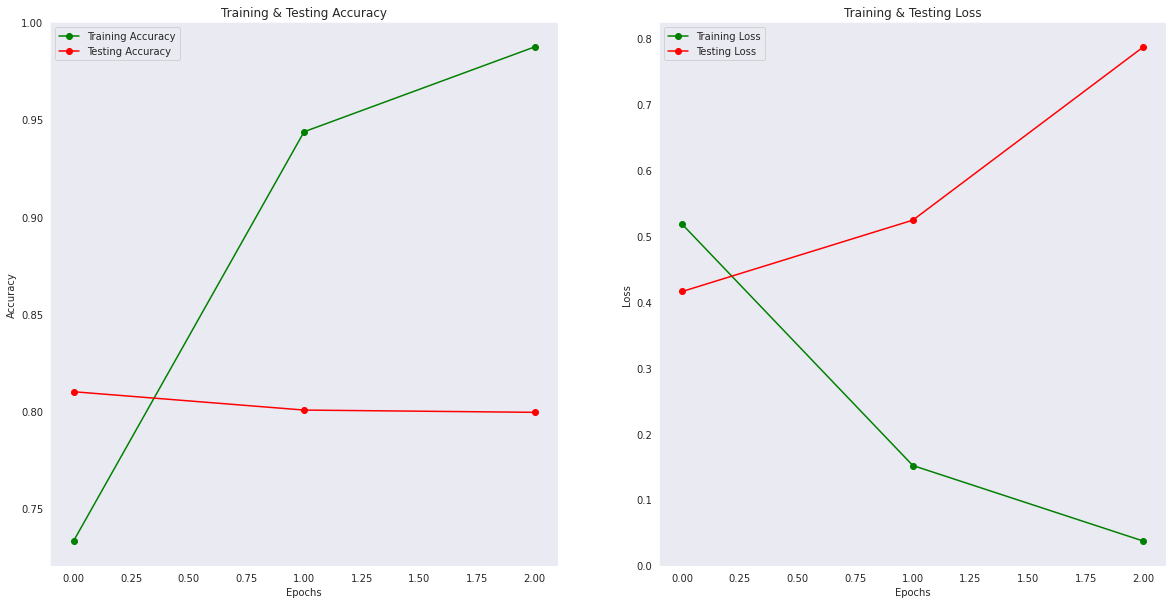

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()